# Regression modelling

This notebook shows how `homonim` can help improve regression modelling performance.  It works with aerial imagery and ground truth data from a [study](https://github.com/dugalh/map_thicket_agc) that investigated aboveground carbon (AGC) mapping in the thicket biome, South Africa.  

The notebook uses the APIs of `homonim` and other packages.  Where equivalent CLI commands are available, they are given in the comments.

## Setup

### Install dependencies

`geedim`, `geopandas`, `gdal` and `matplotlib` are required to run the notebook.  You can uncomment the cell below to install them, if they aren't installed already.

In [1]:
# import sys
# if 'conda' in sys.prefix:
#     # install into the conda environment the notebook is being run from
#     !conda install --yes --prefix {sys.prefix} -c conda-forge geedim geopandas gdal matplotlib
# else:
#     # install into the conda environment the notebook is being run from
#     !{sys.executable} -m pip install geedim geopandas gdal matplotlib

In [2]:
# imports used by more than one cell
import logging
import warnings
from pathlib import Path
from matplotlib import pyplot
import numpy as np
import rasterio as rio
from tqdm.auto import tqdm

import geedim as gd

logging.basicConfig(level=logging.ERROR)

## Download aerial images

The aerial imagery consists of 4 50cm resolution, 4 band images, captured on 8-9 May 2015, covering a small site in the Baviaanskloof.  The images are orthorecified but otherwise unadjusted i.e. without colour balancing, gamma correction etc.  Imagery was captured and supplied by [National Geo-spatial Information (NGI)](https://ngi.dalrrd.gov.za/index.php/what-we-do/aerial-photography-and-imagery).

In this step, we create an *images* sub-folder, then download & extract the [source aerial images](https://zenodo.org/record/7114702) into it.  It is a large download (~2 GB), so you may want to do it manually.  Alternatively, run the code segment below.  

In [3]:
from zipfile import ZipFile
from urllib import request

src_url = 'https://zenodo.org/record/7130228/files/Ngi_May2015_Source.zip'
images_path = Path('images')
images_path.mkdir(exist_ok=True)
zip_path = images_path.joinpath('temp.zip')

# download zip file if it doesn't exist
if not zip_path.exists():
    response = request.urlopen(src_url)
    with tqdm(
        total=response.length, desc='Download', unit='B', unit_scale=True, 
        dynamic_ncols=True
    ) as pbar, open(zip_path, 'wb')  as fout:
        for chunk in response:
            fout.write(chunk)
            pbar.update(len(chunk))

# extract zip file
with ZipFile(zip_path) as zip_file:
     for file in tqdm(
        zip_file.namelist(), desc='Extract', dynamic_ncols=True
    ):
        zip_file.extract(member=file, path=images_path)

Extract:   0%|                                                                                   | 0/5 [00:00<…

## Download reference image

This section shows how to search for a Sentinel-2 reference image using ``geedim``.  Sentinel-2 was selected for this example because it has bands that are spectrally similar to the aerial image bands, and a relatively high spatial resolution (10m).  Normally it is best to search for a reference image that is concurrent with the source imagery, but the Sentinel-2 archive begins after the source capture date (8-9 May 2015).  So, we search for the soonest possible reference after this date.  Thicket vegetation is slow growing and the study site was undisturbed over the time between the aerial and Sentinel-2 captures, so there is little change between source and reference images.

In [4]:
gd.Initialize()
src_mosaic_path = Path('images/Ngi_May2015_OrthoNgiDem_Source_Mosaic.vrt')

# create a search region that covers the source image mosaic
region = gd.utils.get_bounds(src_mosaic_path)

# create and search the Sentinel-2 collection
s2_coll = gd.MaskedCollection.from_name('COPERNICUS/S2')
s2_coll = s2_coll.search('2015-05-08', '2015-10-30', region)
print('Image property descriptions:\n\n' + s2_coll.schema_table)
print('\nSearch Results:\n\n' + s2_coll.properties_table)

# equivalent geedim command line:
#!geedim search -c s2-toa -s 2015-05-08 -e 2015-10-30 -r {src_mosaic_path}

Image property descriptions:

ABBREV     NAME                             DESCRIPTION
---------  -------------------------------  ---------------------------------------
ID         system:id                        Earth Engine image id
DATE       system:time_start                Image capture date/time (UTC)
FILL       FILL_PORTION                     Portion of valid pixels (%)
CLOUDLESS  CLOUDLESS_PORTION                Portion of cloud/shadow free pixels (%)
RADQ       RADIOMETRIC_QUALITY              Radiometric quality check
GEOMQ      GEOMETRIC_QUALITY                Geometric quality check
SAA        MEAN_SOLAR_AZIMUTH_ANGLE         Solar azimuth angle (deg)
SZA        MEAN_SOLAR_ZENITH_ANGLE          Solar zenith angle (deg)
VAA        MEAN_INCIDENCE_AZIMUTH_ANGLE_B1  View (B1) azimuth angle (deg)
VZA        MEAN_INCIDENCE_ZENITH_ANGLE_B1   View (B1) zenith angle (deg)

Search Results:

ID                                                   DATE             FILL CLOUDLESS RADQ   

Now we download the first 100% cloudless image - *COPERNICUS/S2/20151023T081112_20151023T081949_T34HGH*.

In [5]:
ref_path = Path('images/s2_reference.tif')
gd_image = gd.MaskedImage.from_id(
    'COPERNICUS/S2/20151023T081112_20151023T081949_T34HGH', mask=True
)
gd_image.download(ref_path, region=region, overwrite=True)

# equivalent geedim command line:
# !geedim download -i COPERNICUS/S2/20151023T081112_20151023T081949_T34HGH --mask -r {src_file}

s2_reference.tif: |                                                   | 0.00/68.9M (raw) [  0.0%] in 00:00 (et…

## Surface reflectance correction

In the next step, we correct the aerial images by fusion with the Sentinel-2 reference. We use `homonim`'s *RasterFuse* class, a kernel size of 15x15 pixels and the *gain-blk-offset* model.

In [6]:
from homonim import RasterFuse, Model

# paths to source aerial images
src_paths = [
    Path(f'images/3323d_2015_1001_02_00{i}_RGBN_CMP.tif') 
    for i in [76, 78, 80, 81]
]
# paths to corrected images to create
corr_paths = [
    src_path.parent.joinpath(f'{src_path.stem}_FUSE.tif')
    for src_path in src_paths
]

In [7]:
# sentinel-2 bands that correpond to the red, green, blue and near-infrared bands of 
# the aerial images
ref_bands = [4, 3, 2, 8]

out_profile = RasterFuse.create_out_profile(dtype='uint16', nodata=0)
for src_path, corr_path in zip(src_paths, corr_paths):
    with RasterFuse(
        src_path, ref_path, ref_bands=ref_bands
    ) as raster_fuse:
        raster_fuse.process(
            corr_path, Model.gain_blk_offset, (15, 15), overwrite=True,
            out_profile=out_profile,
        ) 

    # equivalent homonim command line:
    # !homonim fuse -m gain-blk-offset -k 15 15 -rb 4 -rb 3 -rb 2 -rb 8 -od images {src_path} {ref_path}

  0%|                                                                                             |0/8 blocks …

  0%|                                                                                            |0/32 blocks …

  0%|                                                                                            |0/32 blocks …

  0%|                                                                                            |0/32 blocks …

Now we create a VRT mosaic of the corrected images to use in the visualisation and evaluation steps.

In [8]:
from osgeo import gdal

# strictly, one should avoid using GDAL and rasterio together, but it doesn't
# create conflicts here
corr_mosaic_path = Path('images/Ngi_May2015_OrthoNgiDem_Corrected_Mosaic.vrt')
ds = gdal.BuildVRT(
    str(corr_mosaic_path.absolute()), [str(cp) for cp in corr_paths]
)
ds.FlushCache()

## Visualise

In this section we produce a map of the AGC ground truth values and locations on the corrected mosaic.  We start by loading the AGC ground truth into a `geopandas` *GeoDataFrame*.

In [9]:
import geopandas as gpd

plot_agc_gdf = gpd.GeoDataFrame.from_file(
    'https://raw.githubusercontent.com/dugalh/map_thicket_agc/main/'
    'data/outputs/geospatial/gef_plot_polygons_with_agc_v2.gpkg' 
)

Then we create and format the map.

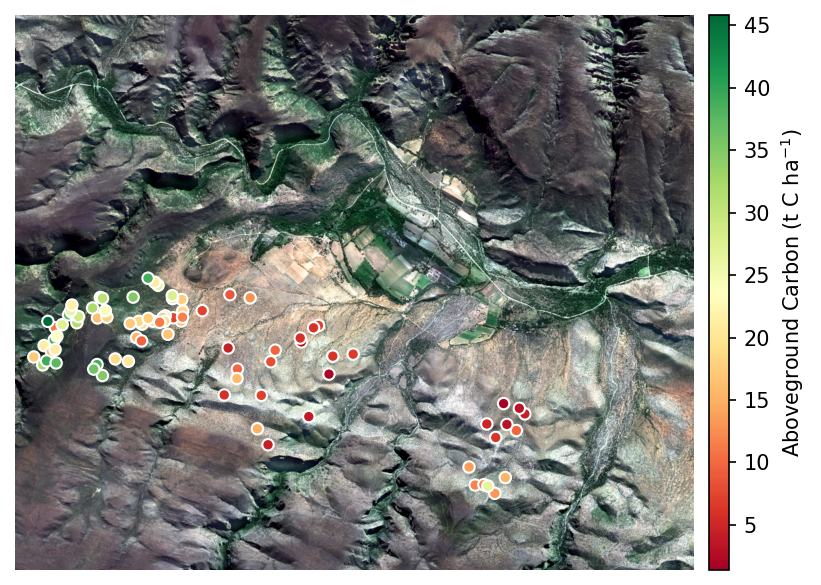

In [16]:
from rasterio.plot import show
from mpl_toolkits.axes_grid1 import make_axes_locatable

indexes = [1, 2, 3]  # red, green, blue band indices
ds_fact = 4  # factor by which to downsample bands

fig, ax = pyplot.subplots(1, 1, tight_layout=True, figsize=(6, 4), dpi=150)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.1)

# read, normalise and display corrected mosaic
with rio.open(corr_mosaic_path, 'r') as corr_ds:
    # downsampled band shape & transform
    ds_shape = tuple(np.round(np.array(corr_ds.shape) / ds_fact).astype('int'))
    transform = corr_ds.transform * rio.Affine.scale(ds_fact)
    # read image and downsample
    array = corr_ds.read(indexes=indexes, out_dtype='float32', out_shape=ds_shape)

    # change nodata value to nan
    mask = np.any(array == corr_ds.nodata, axis=(0))
    array[:, mask] = np.nan
    
    # 'normalise' image 2%-98% -> 0-1
    for bi in range(len(indexes)):
        array[bi] -= np.nanpercentile(array[bi], 2)
        array[bi] /= np.nanpercentile(array[bi], 98)
        array[bi] = np.clip(array[bi], 0, 1)

    ax = show(array, transform=transform, interpolation='bilinear', ax=ax)

# plot colour coded points for each AGC ground truth plot
_plot_agc_gdf = plot_agc_gdf.to_crs(corr_ds.crs)
_plot_agc_gdf.geometry = _plot_agc_gdf.geometry.centroid
_plot_agc_gdf.AgcHa /= 1000
ax = _plot_agc_gdf.plot(
    'AgcHa', kind='geo', legend=True, ax=ax, cmap='RdYlGn', cax=cax, edgecolor='white', 
    legend_kwds=dict(label='Aboveground Carbon (t C ha$^{-1}$)', orientation='vertical'),
    linewidth=1, markersize=30, 
)

# zoom in
_ = ax.axis((86494.06047619047, 94313.07562770562, -3717680.7510822513, -3711286.8766233767))
_ = ax.axis('off')
# fig.savefig('../case_studies/regression_modelling-agc_map.jpg', dpi=150)

## Evaluate

The evaluation compares the correlation of source and corrected NDVI with AGC ground truth.  From this basic comparison, we have an indication of the improvement in the relevance, or explanatory power of the image due to surface reflectance correction.  NDVI is used just for demonstration purposes; there may be other spectral indices and image features that better explain AGC.

Here we find the mean NDVI values for each ground truth plot, for both source and corrected images.

In [11]:
from rasterio import features, windows
from homonim import utils

src_mosaic_path = Path('images/Ngi_May2015_OrthoNgiDem_Source_Mosaic.vrt')

ndvis = []
for im_path in [src_mosaic_path, corr_mosaic_path]:    
    ndvi = []
    with warnings.catch_warnings(), rio.open(im_path, 'r') as ds:        
        warnings.simplefilter('ignore')     # ignore shapely deprecation warning
        # loop over ground truth plots
        for id, plot in tqdm(
            plot_agc_gdf.to_crs(ds.crs).iterrows(), total=plot_agc_gdf.shape[0],
            desc=im_path.name, dynamic_ncols=True,
        ):
            # find a rasterio window that contains the plot polygon
            bounds = features.bounds(plot.geometry)
            win = windows.from_bounds(*bounds, transform=ds.transform)
            win = utils.expand_window_to_grid(win)

            # read the image array corresponding to the plot window
            array = ds.read(out_dtype='float64', window=win)

            # find a mask for pixels contained inside the plot polygon
            win_transform = ds.window_transform(win)
            mask = ~features.geometry_mask(
                plot.geometry, (win.height, win.width), transform=win_transform
            )

            # find mean NDVI for the plot
            r = array[0, mask]
            nir = array[3, mask]
            ndvi.append(np.mean((nir - r) / (nir + r)))

    ndvis.append(ndvi)

ndvi_dict = dict(zip(['Source', 'Corrected'], ndvis))

Ngi_May2015_OrthoNgiDem_Source_Mosaic.vrt:   0%|                                                | 0/85 [00:00<…

Ngi_May2015_OrthoNgiDem_Corrected_Mosaic.vrt:   0%|                                             | 0/85 [00:00<…

Then we create scatter plots of source / corrected NDVI vs. AGC, and display the corresponding *R*<sup>2</sup> correlation coefficients.

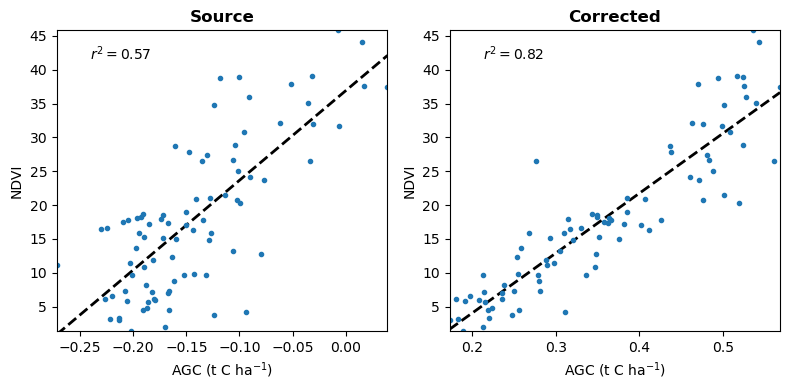

In [18]:
fig, axes = pyplot.subplots(1, 2, tight_layout=True, figsize=(8, 4), dpi=100)
agc = plot_agc_gdf.AgcHa / 1000
for ax, (label, ndvi) in zip(axes, ndvi_dict.items()):
    # plot NDVI vs AGC scattter
    ax.plot(ndvi, agc, '.')

    # find and plot regression line
    coeff, _, _, _ = np.linalg.lstsq(
        np.array([ndvi, np.ones(len(ndvi))]).T, agc, rcond=None
    )
    xlim = [np.min(ndvi), np.max(ndvi)]
    ylim = [np.min(agc), np.max(agc)]    
    yr = np.array(xlim) * coeff[0] + coeff[1]
    ax.plot(xlim, yr, 'k--', lw=2, zorder=-1)
    
    # find R2 correlation coefficient and add to plot
    r2 = np.corrcoef(agc, ndvi)[0, 1] **2
    ax.text(
        .1, 0.9, f'$r^{2}={r2:.2f}$', transform=ax.transAxes, 
        fontweight='bold'
    )

    ax.set_xlabel('AGC (t C ha$^{-1}$)')
    ax.set_ylabel('NDVI')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim) 
    ax.set_title(label, fontweight='bold')    

# fig.savefig('../case_studies/regression_modelling-eval.svg', dpi=100)

## Discussion

Surface reflectance correction reduces unwanted variation due to atmospheric and anisotropic effects, and produces a useful improvement in the correlation between AGC and NDVI.  Based on this, one would expect a regression model built on the corrected data to outperform one built on the source data.  